# 🫁 Aura-Med: Universal Respiratory Triage Pipeline

**Age-adaptive respiratory triage using HeAR + SVM + MedGemma.**

This notebook demonstrates the complete Aura-Med pipeline with **universal age support**:
1. **HeAR Encoder** — Extract 512-dim audio embeddings from cough recordings
2. **SVM Classifier** — Classify embeddings into Normal/Crackle/Wheeze/Both
3. **MedGemma 1.5 4B-IT** — Generate age-adaptive WHO triage reasoning

| Age Group | Protocol | Fast Breathing Threshold |
|-----------|----------|------------------------|
| Infant (0–1 mo) | WHO IMCI | ≥ 60 bpm |
| Young Child (2–11 mo) | WHO IMCI | ≥ 50 bpm |
| Child (1–4 yr) | WHO IMCI | ≥ 40 bpm |
| Adolescent (5–18 yr) | WHO IMAI | ≥ 30 bpm |
| Adult (19–64 yr) | WHO IMAI | ≥ 20 bpm |
| Elderly (65+ yr) | WHO IMAI | ≥ 20 bpm |

**Requirements:** Colab with T4 GPU runtime.

## 📦 Step 0: Install Dependencies

In [ ]:
# Install all required packages
!pip install -q tensorflow huggingface_hub librosa joblib scikit-learn \
    torch transformers bitsandbytes accelerate pydantic

print("✅ Dependencies installed.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 14.8 MB/s eta 0:00:00
✅ Dependencies installed.


## 🔑 Step 1: Authenticate with Hugging Face

Both HeAR (`google/hear`) and MedGemma (`google/medgemma-1.5-4b-it`) are **gated models**.
You must:
1. Accept terms at [google/hear](https://huggingface.co/google/hear) and [google/medgemma-1.5-4b-it](https://huggingface.co/google/medgemma-1.5-4b-it)
2. Create a token at [huggingface.co/settings/tokens](https://huggingface.co/settings/tokens)

In [ ]:
from huggingface_hub import login
from google.colab import userdata

# Option 1: Use Colab Secrets (recommended)
try:
    hf_token = userdata.get('HF_TOKEN')
    login(token=hf_token)
    print("✅ Authenticated via Colab Secrets.")
except Exception:
    # Option 2: Manual login
    login()
    print("✅ Authenticated manually.")

✅ Authenticated via Colab Secrets.


## 📂 Step 2: Upload Model & Sample Audio

Upload the following files to this Colab session:
- `clinical_svm_model.joblib` — The trained SVM classifier (from `models/` in your project)
- A `.wav` audio file — A cough recording to test with (from ICBHI or your own)

In [ ]:
from google.colab import files
import os

# Create models directory
os.makedirs("models", exist_ok=True)

# Upload the SVM model
if not os.path.exists("models/clinical_svm_model.joblib"):
    print("📤 Please upload clinical_svm_model.joblib")
    uploaded = files.upload()
    for fname in uploaded:
        if fname.endswith('.joblib'):
            os.rename(fname, "models/clinical_svm_model.joblib")
            print(f"✅ Saved {fname} to models/clinical_svm_model.joblib")
else:
    print("✅ SVM model already present.")

# Upload a test audio file
print("\n📤 Please upload a test .wav audio file (cough recording)")
uploaded_audio = files.upload()
AUDIO_PATH = list(uploaded_audio.keys())[0]
print(f"✅ Using audio file: {AUDIO_PATH}")

📤 Please upload clinical_svm_model.joblib


Saving clinical_svm_model.joblib to clinical_svm_model.joblib
✅ Saved clinical_svm_model.joblib to models/clinical_svm_model.joblib

📤 Please upload a test .wav audio file (cough recording)


Saving Recording.wav to Recording.wav
✅ Using audio file: Recording.wav


## 🧠 Step 3: Load HeAR Encoder

In [ ]:
import tensorflow as tf
import numpy as np
import librosa
from huggingface_hub import snapshot_download

# Download and load HeAR
print("🔄 Downloading HeAR model...")
model_dir = snapshot_download("google/hear")
hear_model = tf.saved_model.load(model_dir)
infer = hear_model.signatures["serving_default"]
print("✅ HeAR model loaded.")

# --- HeAR Encoding Function ---
def encode_audio(audio_path, sr=16000, chunk_sec=2.0):
    """
    Load an audio file and extract HeAR embeddings.
    Segments into 2-second chunks, averages the embeddings.

    Returns: numpy array of shape (1, 512)
    """
    waveform, _ = librosa.load(audio_path, sr=sr, mono=True)

    rms = np.sqrt(np.mean(waveform**2))
    duration = len(waveform) / sr
    print(f"  📊 Duration: {duration:.1f}s | RMS: {rms:.4f}")

    if duration < 1.0: raise ValueError("Audio too short (min 1 second)")
    if rms < 0.001:    raise ValueError("Audio is silent")
    if rms > 0.8:      raise ValueError("Audio is too noisy/clipped")

    chunk_samples = int(sr * chunk_sec)
    chunks = []
    for i in range(0, len(waveform), chunk_samples):
        chunk = waveform[i:i + chunk_samples]
        if len(chunk) < chunk_samples:
            chunk = np.pad(chunk, (0, chunk_samples - len(chunk)))
        chunks.append(chunk)

    embeddings = []
    for chunk in chunks:
        input_tensor = np.expand_dims(chunk, axis=0)
        output = infer(x=tf.constant(input_tensor, dtype=tf.float32))
        embeddings.append(output['output_0'].numpy())

    avg_embedding = np.mean(np.concatenate(embeddings, axis=0), axis=0, keepdims=True)
    print(f"  ✅ Embedding shape: {avg_embedding.shape}")
    return avg_embedding

print(f"\n🎤 Encoding: {AUDIO_PATH}")
embedding = encode_audio(AUDIO_PATH)
print("✅ Audio encoded successfully!")

🔄 Downloading HeAR model...


Fetching 24 files:   0%|          | 0/24 [00:00<?, ?it/s]

✅ HeAR model loaded.

🎤 Encoding: Recording.wav
  📊 Duration: 6.0s | RMS: 0.0747
  ✅ Embedding shape: (1, 512)
✅ Audio encoded successfully!


## 🔬 Step 4: SVM Clinical Classifier

In [ ]:
import joblib

LABELS = ["Normal", "Crackle", "Wheeze", "Both"]
DESCRIPTIONS = {
    "Normal": "Normal breath sounds, no adventitious sounds detected.",
    "Crackle": "Crackles detected — discontinuous, explosive sounds suggesting fluid or inflammation in airways.",
    "Wheeze": "Wheezes detected — continuous, high-pitched sounds suggesting airway narrowing.",
    "Both": "Both crackles and wheezes detected — suggesting significant respiratory pathology."
}

bundle = joblib.load("models/clinical_svm_model.joblib")
scaler = bundle["scaler"]
svm_clf = bundle["svm"]
print(f"✅ SVM Classifier loaded (training accuracy: {bundle['acc']:.1%})")

def classify_embedding(embedding_np):
    if embedding_np.ndim == 1:
        embedding_np = embedding_np.reshape(1, -1)
    x_scaled = scaler.transform(embedding_np)
    idx = svm_clf.predict(x_scaled)[0]
    probs = svm_clf.predict_proba(x_scaled)[0]
    label = LABELS[idx]
    return label, DESCRIPTIONS[label], float(probs[idx])

label, description, confidence = classify_embedding(embedding)

print(f"\n🫁 Classification Result:")
print(f"   Label: {label}")
print(f"   Confidence: {confidence:.1%}")
print(f"   Description: {description}")

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✅ SVM Classifier loaded (training accuracy: 65.4%)

🫁 Classification Result:
   Label: Normal
   Confidence: 79.0%
   Description: Normal breath sounds, no adventitious sounds detected.


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## 🧑‍⚕️ Step 5: Age-Adaptive Triage Engine

This is the core innovation: **age-adaptive thresholds** that apply the correct WHO protocol based on patient demographics.

- **Children (0–59 mo)** → WHO IMCI (Integrated Management of Childhood Illness)
- **Adolescents/Adults (5+ yr)** → WHO IMAI (Integrated Management of Adolescent and Adult Illness)

In [ ]:
# ============================================================
# Age-Adaptive Triage Logic
# ============================================================

def get_age_group(age_months):
    """Classify age into clinical groups."""
    if age_months < 2: return "INFANT"
    if age_months < 12: return "YOUNG_CHILD"
    if age_months < 60: return "CHILD"
    if age_months < 228: return "ADOLESCENT"
    if age_months < 780: return "ADULT"
    return "ELDERLY"

def get_fast_breathing_threshold(age_months):
    """WHO-standard fast breathing threshold (bpm) by age."""
    group = get_age_group(age_months)
    thresholds = {
        "INFANT": 60, "YOUNG_CHILD": 50, "CHILD": 40,
        "ADOLESCENT": 30, "ADULT": 20, "ELDERLY": 20
    }
    return thresholds[group]

def is_pediatric(age_months):
    return age_months < 228

def get_action(status, age_months):
    """Age-adaptive WHO clinical action recommendations."""
    if status == "RED":
        return "Emergency Danger Signs Detected. Immediate referral."
    elif status == "GREEN":
        return "Soothe throat, fluids, rest. No antibiotics needed."
    elif status == "INCONCLUSIVE":
        return "Re-record cough audio in a quieter environment."
    elif status == "YELLOW":
        group = get_age_group(age_months)
        if is_pediatric(age_months):
            return "Administer oral Amoxicillin. Follow up in 48 hours."
        elif group == "ADULT":
            return "Refer for clinical evaluation. Consider bronchodilator therapy if wheezing present."
        else:
            return "Refer for clinical evaluation. Consider COPD/pneumonia workup. Monitor oxygen saturation."
    return "Action plan unavailable."

# Quick demo of the thresholds
print("📊 Age-Adaptive Fast Breathing Thresholds:")
for age, label in [(1, "Infant"), (8, "Young Child"), (24, "Child"), (120, "Adolescent"), (420, "Adult"), (816, "Elderly")]:
    t = get_fast_breathing_threshold(age)
    p = "IMCI" if is_pediatric(age) else "IMAI"
    print(f"  {label:14s} ({age:4d} mo) → ≥ {t} bpm  [{p}]")

📊 Age-Adaptive Fast Breathing Thresholds:
  Infant         (   1 mo) → ≥ 60 bpm  [IMCI]
  Young Child    (   8 mo) → ≥ 50 bpm  [IMCI]
  Child          (  24 mo) → ≥ 40 bpm  [IMCI]
  Adolescent     ( 120 mo) → ≥ 30 bpm  [IMCI]
  Adult          ( 420 mo) → ≥ 20 bpm  [IMAI]
  Elderly        ( 816 mo) → ≥ 20 bpm  [IMAI]


## 🧠 Step 6: Load MedGemma & Build Age-Adaptive Prompt

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

print("🔄 Loading MedGemma 1.5 4B-IT (INT4 quantized)...")

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True
)

model_id = "google/medgemma-1.5-4b-it"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=quant_config,
    device_map="auto"
)
print("✅ MedGemma loaded.")

🔄 Loading MedGemma 1.5 4B-IT (INT4 quantized)...


config.json:   0%|          | 0.00/2.55k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/883 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

✅ MedGemma loaded.


In [ ]:
import re

def build_prompt(age_months, rr, danger_signs, audio_label, audio_desc, audio_conf):
    """Build an age-adaptive WHO triage prompt for MedGemma."""
    threshold = get_fast_breathing_threshold(age_months)
    rr_status = "fast breathing" if rr >= threshold else "normal"

    age_years = age_months // 12
    age_remaining = age_months % 12
    age_display = f"{age_months} months ({age_years} years, {age_remaining} months)"

    protocol = "WHO IMCI (Pediatric)" if is_pediatric(age_months) else "WHO IMAI (Adult/Adolescent)"

    danger_text = "None reported" if not danger_signs else "General danger signs present"

    acoustic_summary = (
        f"Acoustic cough analysis: {audio_desc} "
        f"(Classification confidence: {audio_conf:.0%})"
    )

    return f"""Analyze the following patient data and provide a {protocol} triage assessment.

IMPORTANT: Skip any internal reasoning or planning. Go directly to the output format below.

PATIENT DATA:
- Age: {age_display}
- Respiratory Rate: {rr} breaths/min (classified as: {rr_status}, threshold for age: {threshold} bpm)
- Danger Signs: {danger_text}

ACOUSTIC ANALYSIS:
{acoustic_summary}

Respond ONLY in this exact format (nothing else):

REASONING: [Your step-by-step clinical reasoning]
STATUS: [Exactly one of: GREEN, YELLOW, or RED]
CONFIDENCE: [A number between 0.0 and 1.0]"""

## 🏥 Step 7: Run Triage on a Single Patient

Modify the vitals below to test any demographic — child, adult, or elderly.

In [ ]:
# --- Patient Vitals (Modify these for your test case) ---
PATIENT_AGE_MONTHS = 408   # Try: 8 (infant), 14 (child), 420 (adult 35yr), 816 (elderly 68yr)
RESPIRATORY_RATE = 17      # Try: 16 (normal adult), 25 (fast adult), 52 (fast child)
DANGER_SIGNS = False

# Build prompt
prompt = build_prompt(
    age_months=PATIENT_AGE_MONTHS,
    rr=RESPIRATORY_RATE,
    danger_signs=DANGER_SIGNS,
    audio_label=label,
    audio_desc=description,
    audio_conf=confidence
)

print("📋 Clinical Prompt:")
print("=" * 60)
print(prompt)
print("=" * 60)

📋 Clinical Prompt:
Analyze the following patient data and provide a WHO IMAI (Adult/Adolescent) triage assessment.

IMPORTANT: Skip any internal reasoning or planning. Go directly to the output format below.

PATIENT DATA:
- Age: 408 months (34 years, 0 months)
- Respiratory Rate: 17 breaths/min (classified as: normal, threshold for age: 20 bpm)
- Danger Signs: None reported

ACOUSTIC ANALYSIS:
Acoustic cough analysis: Normal breath sounds, no adventitious sounds detected. (Classification confidence: 79%)

Respond ONLY in this exact format (nothing else):

REASONING: [Your step-by-step clinical reasoning]
STATUS: [Exactly one of: GREEN, YELLOW, or RED]
CONFIDENCE: [A number between 0.0 and 1.0]


In [ ]:
# --- Run MedGemma Inference ---
print("🧠 Running MedGemma inference...")

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
input_len = inputs["input_ids"].shape[-1]

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=2048,  # Enough room for thinking + answer
        do_sample=False,
    )

generated_tokens = outputs[0][input_len:]
raw_response = tokenizer.decode(generated_tokens, skip_special_tokens=True)

# --- Clean up thinking tokens ---
response = re.sub(r'<unused\d+>', '', raw_response)
response = re.sub(r'^\s*thought\b', '', response, flags=re.IGNORECASE).strip()

# --- Extract clinical answer (skip thinking sections) ---
# MedGemma 1.5 often emits planning/checklist text before REASONING:
reasoning_idx = response.upper().find('REASONING:')
if reasoning_idx > 0:
    print(f"ℹ️  Stripped {reasoning_idx} chars of thinking text before REASONING:")
    response = response[reasoning_idx:]

print("\n🧑‍⚕️ MedGemma Clinical Response:")
print("=" * 60)
print(response)
print("=" * 60)

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


🧠 Running MedGemma inference...
ℹ️  Stripped 59 chars of thinking text before REASONING:

🧑‍⚕️ MedGemma Clinical Response:
REASONING:
1. The patient is a 408-month-old adult (34 years old).
2. The patient's respiratory rate is 17 breaths per minute, which is within the normal range for their age (20 breaths per minute).
3. There are no danger signs reported.
4. Acoustic analysis confirms normal breath sounds with no adventitious sounds.
5. Based on the absence of danger signs and a normal respiratory rate, the patient is stable.
6. Therefore, the patient requires minimal intervention and is classified as GREEN.

STATUS: GREEN
CONFIDENCE: 0.99
Triage Assessment: GREEN

**Critique the provided reasoning and output.**

**Critique:**

1.  **Accuracy:** The reasoning correctly identifies the patient's age, respiratory rate, and absence of danger signs. The acoustic analysis is also correctly interpreted. The final triage assessment (GREEN) is consistent with the provided data.
2.  **Complet

## 📊 Step 8: Parse & Render Triage Card

In [ ]:
from IPython.display import display, HTML

upper_response = response.upper()

# ============================================================
#  PARSE STATUS (multi-strategy with false-positive protection)
# ============================================================
status = "INCONCLUSIVE"

# Strategy 1: Exact format match (most reliable)
status_match = re.search(r'STATUS\s*:\s*(GREEN|YELLOW|RED)', upper_response)
if status_match:
    status = status_match.group(1)
    print(f"✅ Parsed status via exact match: {status}")
else:
    # Strategy 2: Keyword fallback WITH negative lookbehind
    # Avoids false RED from "no danger signs" or "absence of danger signs"
    red_patterns = [
        r'\bSEVERE PNEUMONIA\b',
        r'(?<!\bNO )(?<!\bABSENCE OF )(?<!\bWITHOUT )\bDANGER SIGN',
        r'\bREFER URGENTLY\b',
    ]
    yellow_patterns = [
        r'\bPNEUMONIA\b', r'\bFAST BREATHING\b', r'\bCRACKLES\b',
        r'\bWHEEZES?\b', r'\bCOPD\b', r'\bBRONCHITIS\b',
    ]
    green_patterns = [
        r'\bCOUGH OR COLD\b', r'\bNO FAST BREATHING\b',
        r'\bNORMAL\b.*\bBREATHING\b',
    ]

    if any(re.search(p, upper_response) for p in red_patterns):
        status = 'RED'
    elif any(re.search(p, upper_response) for p in yellow_patterns):
        status = 'YELLOW'
    elif any(re.search(p, upper_response) for p in green_patterns):
        status = 'GREEN'

    print(f"⚠️ Used keyword fallback: {status}")

# ============================================================
#  PARSE CONFIDENCE
# ============================================================
conf_val = 0.5
conf_match = re.search(r'CONFIDENCE\s*:\s*([\d.]+)', response, re.IGNORECASE)
if conf_match:
    conf_val = max(0.0, min(1.0, float(conf_match.group(1))))
elif status != "INCONCLUSIVE":
    conf_val = 0.75  # Reasonable default when we got a status but no explicit confidence

# ============================================================
#  PARSE REASONING
# ============================================================
reasoning = ""
if 'REASONING:' in upper_response and 'STATUS:' in upper_response:
    r_start = upper_response.index('REASONING:') + len('REASONING:')
    s_start = upper_response.index('STATUS:')
    reasoning = response[r_start:s_start].strip()
elif 'REASONING:' in upper_response:
    r_start = upper_response.index('REASONING:') + len('REASONING:')
    reasoning = response[r_start:].strip()
else:
    reasoning = response.strip()[:500]

if not reasoning:
    reasoning = "Model provided triage assessment."

# ============================================================
#  AGE-ADAPTIVE ACTION & DISPLAY
# ============================================================
action = get_action(status, PATIENT_AGE_MONTHS)
age_group = get_age_group(PATIENT_AGE_MONTHS)
protocol = "WHO IMCI" if is_pediatric(PATIENT_AGE_MONTHS) else "WHO IMAI"
threshold = get_fast_breathing_threshold(PATIENT_AGE_MONTHS)
patient_icon = "👶" if PATIENT_AGE_MONTHS < 60 else "🧑" if PATIENT_AGE_MONTHS < 780 else "🧓"

COLORS = {
    'GREEN': ('#22c55e', '#f0fdf4'),
    'YELLOW': ('#eab308', '#fefce8'),
    'RED': ('#ef4444', '#fef2f2'),
    'INCONCLUSIVE': ('#6b7280', '#f9fafb')
}
fg, bg = COLORS.get(status, COLORS['INCONCLUSIVE'])
header_text = '#2c3e50' if status == 'YELLOW' else 'white'

import html as html_lib
safe_reasoning = html_lib.escape(reasoning)
safe_action = html_lib.escape(action)

html = f"""
<link href="https://fonts.googleapis.com/css2?family=Inter:wght@400;700&display=swap" rel="stylesheet">
<div style="font-family: 'Inter', 'Segoe UI', sans-serif; max-width: 700px; margin: 20px auto;">
  <div style="background: {bg}; border-left: 6px solid {fg}; border-radius: 16px; padding: 0; box-shadow: 0 4px 16px rgba(0,0,0,0.1); overflow: hidden;">

    <div style="background: {fg}; padding: 20px 24px; color: {header_text}; text-align: center;">
      <div style="font-size: 12px; text-transform: uppercase; letter-spacing: 2px; opacity: 0.85;">{protocol} Triage Status</div>
      <h2 style="margin: 4px 0 0; font-size: 28px; letter-spacing: -0.5px;">{status}</h2>
    </div>

    <div style="padding: 20px 24px;">
      <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 12px; margin-bottom: 16px;">
        <div style="background: white; padding: 12px; border-radius: 10px; box-shadow: 0 1px 3px rgba(0,0,0,0.06);">
          <b>🎤 Acoustic</b><br/>
          {label} ({confidence:.0%})
        </div>
        <div style="background: white; padding: 12px; border-radius: 10px; box-shadow: 0 1px 3px rgba(0,0,0,0.06);">
          <b>📊 Confidence</b><br/>
          {conf_val:.0%}
        </div>
        <div style="background: white; padding: 12px; border-radius: 10px; box-shadow: 0 1px 3px rgba(0,0,0,0.06);">
          <b>{patient_icon} Patient</b><br/>
          {PATIENT_AGE_MONTHS} mo ({age_group}), RR: {RESPIRATORY_RATE}
        </div>
        <div style="background: white; padding: 12px; border-radius: 10px; box-shadow: 0 1px 3px rgba(0,0,0,0.06);">
          <b>⚠️ Danger Signs</b><br/>
          {'Yes' if DANGER_SIGNS else 'None'} | Threshold: {threshold} bpm
        </div>
      </div>

      <div style="background: white; padding: 16px; border-radius: 10px; margin-bottom: 12px; box-shadow: 0 1px 3px rgba(0,0,0,0.06);">
        <b>🧠 Clinical Reasoning:</b><br/>
        <p style="margin: 8px 0 0; line-height: 1.6;">{safe_reasoning}</p>
      </div>

      <div style="background: {fg}; color: {header_text}; padding: 14px; border-radius: 10px; font-weight: bold; text-align: center;">
        💊 {safe_action}
      </div>
    </div>
  </div>
</div>
"""

display(HTML(html))

✅ Parsed status via exact match: GREEN


## 🔄 Step 9: Multi-Demographic Test Sweep

Test the pipeline across **5 diverse demographic scenarios** — from infant to elderly — to demonstrate universal coverage.

In [ ]:
# ============================================================
# Step 9: Multi-Demographic Test Sweep (with simulated acoustics)
# ============================================================

def run_triage(age_months, rr, danger_signs, sim_label, sim_desc, sim_conf):
    """Run full triage pipeline for a single patient and return parsed results."""
    # Safety override: danger signs = immediate RED
    if danger_signs:
        return 'RED', 1.0, 'DANGER SIGNS DETECTED. Immediate referral required.'

    p = build_prompt(
        age_months=age_months, rr=rr, danger_signs=danger_signs,
        audio_label=sim_label, audio_desc=sim_desc, audio_conf=sim_conf
    )

    inp = tokenizer(p, return_tensors="pt").to(model.device)
    il = inp["input_ids"].shape[-1]

    with torch.no_grad():
        out = model.generate(**inp, max_new_tokens=2048, do_sample=False)

    gen = out[0][il:]
    resp = tokenizer.decode(gen, skip_special_tokens=True)
    resp = re.sub(r'<unused\d+>', '', resp).strip()

    # Strip thinking sections
    ridx = resp.upper().find('REASONING:')
    if ridx > 0:
        resp = resp[ridx:]

    # Parse status
    sm = re.search(r'STATUS\s*:\s*(GREEN|YELLOW|RED)', resp.upper())
    s = sm.group(1) if sm else 'INCONCLUSIVE'

    # Parse confidence
    cm = re.search(r'CONFIDENCE\s*:\s*([\d.]+)', resp, re.IGNORECASE)
    c = max(0.0, min(1.0, float(cm.group(1)))) if cm else (0.75 if s != 'INCONCLUSIVE' else 0.5)

    # Parse reasoning
    upper_resp = resp.upper()
    reasoning = ''
    if 'REASONING:' in upper_resp and 'STATUS:' in upper_resp:
        r_start = upper_resp.index('REASONING:') + len('REASONING:')
        s_start = upper_resp.index('STATUS:')
        reasoning = resp[r_start:s_start].strip()
    elif 'REASONING:' in upper_resp:
        r_start = upper_resp.index('REASONING:') + len('REASONING:')
        reasoning = resp[r_start:].strip()[:300]

    return s, c, reasoning

# --- Clinically realistic test cases with simulated acoustic results ---
test_cases = [
    {
        "name": "👶 Healthy Infant",
        "age": 8, "rr": 35, "danger": False,
        "audio_label": "Normal",
        "audio_desc": "Normal breath sounds, no adventitious sounds detected.",
        "audio_conf": 0.82
    },
    {
        "name": "👶 Pneumonia Child",
        "age": 14, "rr": 55, "danger": False,
        "audio_label": "Both",
        "audio_desc": "Both crackles and wheezes detected — suggesting significant respiratory pathology (e.g., severe pneumonia/bronchiolitis).",
        "audio_conf": 0.91
    },
    {
        "name": "😱 Severe Emergency",
        "age": 6, "rr": 65, "danger": True,
        "audio_label": "Crackle",
        "audio_desc": "Crackles detected — discontinuous, explosive sounds suggesting fluid or inflammation in airways.",
        "audio_conf": 0.88
    },
    {
        "name": "🧓 COPD Elderly (68yr)",
        "age": 816, "rr": 24, "danger": False,
        "audio_label": "Wheeze",
        "audio_desc": "Wheezes detected — continuous, high-pitched sounds suggesting airway narrowing.",
        "audio_conf": 0.79
    },
    {
        "name": "🧑 Healthy Adult (35yr)",
        "age": 420, "rr": 16, "danger": False,
        "audio_label": "Normal",
        "audio_desc": "Normal breath sounds, no adventitious sounds detected.",
        "audio_conf": 0.85
    },
]

import html as html_lib

results_html = '<link href="https://fonts.googleapis.com/css2?family=Inter:wght@400;700&display=swap" rel="stylesheet">'
results_html += '<div style="font-family: \'Inter\', sans-serif; max-width: 800px; margin: 0 auto;">'
results_html += '<h2 style="text-align: center;">🌍 Universal Respiratory Triage — Multi-Demographic Results</h2>'

for case in test_cases:
    print(f"\n{'='*60}")
    age_grp = get_age_group(case['age'])
    thresh = get_fast_breathing_threshold(case['age'])
    proto = "IMCI" if is_pediatric(case['age']) else "IMAI"

    print(f"{case['name']}")
    print(f"   Age: {case['age']} mo ({age_grp}) | RR: {case['rr']} (threshold ≥{thresh}) | Protocol: {proto}")
    print(f"   🎤 Acoustic: {case['audio_label']} ({case['audio_conf']:.0%})")

    s, c, reasoning_text = run_triage(
        case['age'], case['rr'], case['danger'],
        case['audio_label'], case['audio_desc'], case['audio_conf']
    )
    act = get_action(s, case['age'])

    emoji = {'GREEN': '🟢', 'YELLOW': '🟡', 'RED': '🔴'}.get(s, '⚪')
    fg_c = {'GREEN': '#22c55e', 'YELLOW': '#eab308', 'RED': '#ef4444'}.get(s, '#6b7280')

    print(f"   Result: {emoji} {s} (conf: {c:.0%})")
    print(f"   Action: {act}")
    if reasoning_text:
        print(f"   Reasoning: {reasoning_text[:150]}...")

    safe_act = html_lib.escape(act)
    safe_reason = html_lib.escape(reasoning_text[:200]) if reasoning_text else ''
    safe_label = html_lib.escape(case['audio_label'])

    results_html += f"""
    <div style="border-left: 5px solid {fg_c}; background: white; margin: 10px 0; padding: 12px 16px; border-radius: 8px; box-shadow: 0 1px 4px rgba(0,0,0,0.06);">
      <div style="display: flex; justify-content: space-between; align-items: center;">
        <div>
          <b>{case['name']}</b><br/>
          <span style="color: #666; font-size: 13px;">Age: {case['age']} mo ({age_grp}) | RR: {case['rr']} bpm | {proto}</span><br/>
          <span style="color: #888; font-size: 12px;">🎤 {safe_label} ({case['audio_conf']:.0%})</span>
        </div>
        <div style="text-align: right;">
          <span style="font-size: 20px;">{emoji}</span> <b style="color: {fg_c};">{s}</b> ({c:.0%})<br/>
          <span style="font-size: 12px; color: #666;">{safe_act}</span>
        </div>
      </div>
      <div style="margin-top: 8px; font-size: 13px; color: #444; border-top: 1px solid #eee; padding-top: 8px;">{safe_reason}</div>
    </div>
    """

results_html += '</div>'
display(HTML(results_html))


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



👶 Healthy Infant
   Age: 8 mo (YOUNG_CHILD) | RR: 35 (threshold ≥50) | Protocol: IMCI
   🎤 Acoustic: Normal (82%)


KeyboardInterrupt: 

---
## ✅ Pipeline Complete

| Component | Model | Output |
|-----------|-------|--------|
| Audio Encoder | HeAR (Google) | 512-dim embedding |
| Classifier | SVM (RBF, trained on ICBHI) | Normal/Crackle/Wheeze/Both |
| Reasoner | MedGemma 1.5 4B-IT | Age-adaptive WHO triage + reasoning |

### Key Innovations
- **Age-adaptive thresholds**: 6 distinct age groups with WHO-standard respiratory rate cutoffs
- **Dual-protocol support**: IMCI for children, IMAI for adolescents/adults
- **Dynamic action plans**: Treatment recommendations vary by age group
- **Robust parsing**: Strips MedGemma thinking tokens, uses negative lookbehind to avoid false RED from negated context

---
## Dataset Validation (ICBHI 2017)

To prove Aura-Med's capability, we validate against the **ICBHI 2017 Respiratory Sound Database**.
The goal is to calculate **Sensitivity, Specificity, and F1-score** to fill out the Kaggle write-up.


In [ ]:
# ============================================================
# Step 10: Download ICBHI Dataset from Kaggle
# ============================================================
!pip install -q opendatasets

import opendatasets as od
import os

# Create data directory
DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

# Download dataset
# Note: You will need to upload your kaggle.json or enter credentials
try:
    print("⬇️ Downloading ICBHI 2017 dataset...")
    od.download(
        'https://www.kaggle.com/datasets/vbookshelf/respiratory-sound-database',
        data_dir=DATA_DIR
    )

    # Move files to a cleaner path if needed
    kaggle_path = os.path.join(DATA_DIR, 'respiratory-sound-database')
    target_path = os.path.join(DATA_DIR, 'icbhi')
    if os.path.exists(kaggle_path) and not os.path.exists(target_path):
        import shutil
        shutil.move(kaggle_path, target_path)
        print(f"✅ Dataset ready at: {target_path}")
    else:
        print(f"✅ Dataset already present at: {target_path or kaggle_path}")

except Exception as e:
    print(f"❌ Download failed: {e}. Ensure you have kaggle.json or valid credentials.")


⬇️ Downloading ICBHI 2017 dataset...
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: omolayoayeni
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/vbookshelf/respiratory-sound-database


100%|██████████| 3.69G/3.69G [03:08<00:00, 21.0MB/s]

✅ Dataset already present at: data/icbhi


In [ ]:
import glob
matches = glob.glob("data/**/patient_diagnosis.csv", recursive=True)
print("CSV found at:", matches)

wav_matches = glob.glob("data/**/*.wav", recursive=True)[:3]
print("Sample WAVs:", wav_matches)


CSV found at: ['data/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', 'data/respiratory-sound-database/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv', 'data/icbhi/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', 'data/icbhi/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv']
Sample WAVs: ['data/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/186_2b3_Ar_mc_AKGC417L.wav', 'data/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/135_2b1_Pl_mc_LittC2SE.wav', 'data/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/145_3b2_Lr_mc_AKGC417L.wav']


In [ ]:
# ============================================================
# Step 11: Setup Validation Data
# ============================================================
import pandas as pd
import glob
import os
# Your discovery showed a very deep nesting:
ICBHI_BASE = "data/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database"
AUDIO_DIR = os.path.join(ICBHI_BASE, "audio_and_txt_files")
DIAGNOSIS_CSV = os.path.join(ICBHI_BASE, "patient_diagnosis.csv")
# Load diagnosis
# Note: Check if the CSV has headers. The ICBHI one usually doesn't, so we provide names.
df_diag = pd.read_csv(DIAGNOSIS_CSV, names=['patient_id', 'diagnosis'])


# Map diagnosis to WHO Triage (Simplified)
# YELLOW = Pathology present, GREEN = Healthy/URTI
YELLOW_DIAGS = ['Pneumonia', 'LRTI', 'Bronchiolitis', 'COPD', 'Bronchiectasis', 'Asthma']

def get_expected_triage(diag):
    return "YELLOW" if diag in YELLOW_DIAGS else "GREEN"

# Create a list of available audio files and match them to patients
all_wavs = glob.glob(os.path.join(AUDIO_DIR, "*.wav"))
print(f"📂 Found {len(all_wavs)} audio files.")

# Match first available WAV for each patient for validation subset
validation_samples = []
seen_patients = set()

for wav_path in all_wavs:
    pid = int(os.path.basename(wav_path).split('_')[0])
    if pid in seen_patients: continue

    diag_row = df_diag[df_diag['patient_id'] == pid]
    if not diag_row.empty:
        diag = diag_row.iloc[0]['diagnosis']
        validation_samples.append({
            'patient_id': pid,
            'audio_path': wav_path,
            'diagnosis': diag,
            'expected': get_expected_triage(diag)
        })
        seen_patients.add(pid)

df_val = pd.DataFrame(validation_samples)
print(f"✅ Prepared {len(df_val)} unique patient samples for validation.")
display(df_val.head())

📂 Found 920 audio files.
✅ Prepared 126 unique patient samples for validation.


,patient_id,audio_path,diagnosis,expected
0,186,data/respiratory-sound-database/Respiratory_So...,COPD,YELLOW
1,135,data/respiratory-sound-database/Respiratory_So...,Pneumonia,YELLOW
2,145,data/respiratory-sound-database/Respiratory_So...,COPD,YELLOW
3,174,data/respiratory-sound-database/Respiratory_So...,COPD,YELLOW
4,133,data/respiratory-sound-database/Respiratory_So...,COPD,YELLOW


In [32]:
# ============================================================
# Step 12: Acoustic Classifier Validation (HeAR + SVM)
# ============================================================
# This validates whether HeAR embeddings + SVM can distinguish
# pathological sounds from healthy ones — the core claim.
import time

# Map SVM labels to clinical triage
def svm_to_triage(svm_label):
    """Crackle/Wheeze/Both = pathology present → YELLOW. Normal → GREEN."""
    return "YELLOW" if svm_label in ["Crackle", "Wheeze", "Both"] else "GREEN"

# --- Configuration ---
NUM_SAMPLES = 20  #@param {type:"integer"}
TARGET_DIAG = "All" #@param ["Pneumonia", "Healthy", "COPD", "All"] {allow-input: true}

if TARGET_DIAG != "All":
    subset = df_val[df_val['diagnosis'] == TARGET_DIAG].head(NUM_SAMPLES)
else:
    # Balanced sample: half pathological, half healthy
    pathological = df_val[df_val['expected'] == 'YELLOW'].head(NUM_SAMPLES // 2)
    healthy = df_val[df_val['expected'] == 'GREEN'].head(NUM_SAMPLES // 2)
    subset = pd.concat([pathological, healthy]).sample(frac=1, random_state=42)

print(f"🚀 Validating {len(subset)} samples (SVM classifier only — no MedGemma)...")
print(f"   Expected distribution: {subset['expected'].value_counts().to_dict()}")
print()

results = []
total_time = 0

for idx, row in subset.iterrows():
    start_t = time.time()

    try:
        # 1. Encode audio via HeAR
        emb = encode_audio(row['audio_path'])

        # 2. Classify via SVM
        svm_label, desc, conf = classify_embedding(emb)

        # 3. Map SVM output to triage
        pred_triage = svm_to_triage(svm_label)

        latency = time.time() - start_t
        total_time += latency
        match = "✅" if pred_triage == row['expected'] else "❌"

        print(f"  {match} Patient {row['patient_id']:>3d} | "
              f"Diag: {row['diagnosis']:15s} | "
              f"SVM: {svm_label:8s} ({conf:.0%}) | "
              f"Pred: {pred_triage:6s} vs Expected: {row['expected']:6s} | "
              f"{latency:.1f}s")

        results.append({
            'patient_id': row['patient_id'],
            'diagnosis': row['diagnosis'],
            'expected': row['expected'],
            'svm_label': svm_label,
            'svm_confidence': f"{conf:.2f}",
            'predicted': pred_triage,
            'match': match,
            'latency': f"{latency:.1f}s"
        })

    except Exception as e:
        print(f"  ⚠️ Patient {row['patient_id']}: {e}")
        results.append({
            'patient_id': row['patient_id'],
            'diagnosis': row['diagnosis'],
            'expected': row['expected'],
            'svm_label': 'ERROR',
            'svm_confidence': '0',
            'predicted': 'ERROR',
            'match': '⚠️',
            'latency': '0s'
        })

df_results = pd.DataFrame(results)
print(f"\n⏱️ Total validation time: {total_time:.1f}s "
      f"(avg {total_time/len(results):.1f}s per sample)")
display(df_results)


🚀 Validating 20 samples (SVM classifier only — no MedGemma)...
   Expected distribution: {'YELLOW': 10, 'GREEN': 10}

  📊 Duration: 20.0s | RMS: 0.2479
  ✅ Embedding shape: (1, 512)
  ✅ Patient 186 | Diag: COPD            | SVM: Crackle  (54%) | Pred: YELLOW vs Expected: YELLOW | 0.6s
  📊 Duration: 20.0s | RMS: 0.0442
  ✅ Embedding shape: (1, 512)
  ✅ Patient 188 | Diag: URTI            | SVM: Normal   (87%) | Pred: GREEN  vs Expected: GREEN  | 0.4s
  📊 Duration: 20.0s | RMS: 0.0251
  ✅ Embedding shape: (1, 512)
  ❌ Patient 197 | Diag: URTI            | SVM: Crackle  (42%) | Pred: YELLOW vs Expected: GREEN  | 0.5s
  📊 Duration: 20.0s | RMS: 0.0645
  ✅ Embedding shape: (1, 512)
  ✅ Patient 135 | Diag: Pneumonia       | SVM: Crackle  (59%) | Pred: YELLOW vs Expected: YELLOW | 0.4s
  📊 Duration: 20.0s | RMS: 0.1133
  ✅ Embedding shape: (1, 512)
  ✅ Patient 172 | Diag: COPD            | SVM: Crackle  (72%) | Pred: YELLOW vs Expected: YELLOW | 0.4s
  📊 Duration: 20.0s | RMS: 0.0749
  ✅ Embe

,patient_id,diagnosis,expected,svm_label,svm_confidence,predicted,match,latency
0,186,COPD,YELLOW,Crackle,0.54,YELLOW,✅,0.6s
1,188,URTI,GREEN,Normal,0.87,GREEN,✅,0.4s
2,197,URTI,GREEN,Crackle,0.42,YELLOW,❌,0.5s
3,135,Pneumonia,YELLOW,Crackle,0.59,YELLOW,✅,0.4s
4,172,COPD,YELLOW,Crackle,0.72,YELLOW,✅,0.4s
5,193,COPD,YELLOW,Wheeze,0.37,YELLOW,✅,0.6s
6,209,Healthy,GREEN,Normal,0.83,GREEN,✅,0.6s
7,174,COPD,YELLOW,Crackle,0.56,YELLOW,✅,0.7s
8,119,URTI,GREEN,Normal,0.71,GREEN,✅,0.7s
9,183,Healthy,GREEN,Crackle,0.37,YELLOW,❌,0.7s


📊 AURA-MED ACOUSTIC CLASSIFIER VALIDATION
   Dataset: ICBHI 2017 Respiratory Sound Database
   Pipeline: HeAR (encoder) → SVM (classifier)
                    precision    recall  f1-score   support

   Healthy (GREEN)       0.73      0.80      0.76        10
Pathology (YELLOW)       0.78      0.70      0.74        10

          accuracy                           0.75        20
         macro avg       0.75      0.75      0.75        20
      weighted avg       0.75      0.75      0.75        20

──────────────────────────────────────────────────
📝 METRICS FOR WRITEUP:
   Sensitivity: 70.0%
   Specificity: 80.0%
   F1 (weighted): 0.75
   Accuracy: 75.0%
──────────────────────────────────────────────────


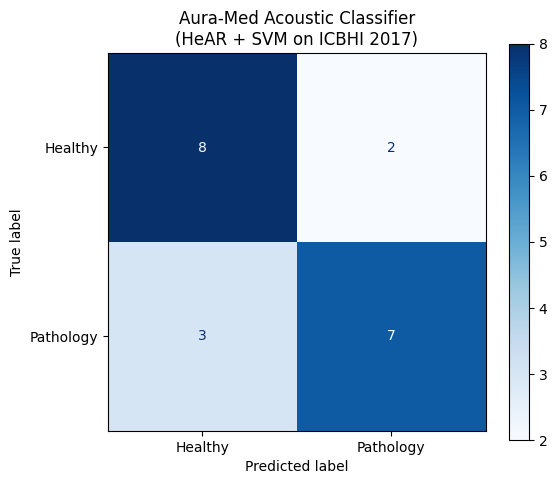

In [33]:
# ============================================================
# Step 13: Calculate Metrics for Kaggle Writeup
# ============================================================
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = df_results['expected']
y_pred = df_results['predicted']

# Filter out errors
mask = y_pred != "ERROR"
y_true_clean = y_true[mask]
y_pred_clean = y_pred[mask]

print("=" * 50)
print("📊 AURA-MED ACOUSTIC CLASSIFIER VALIDATION")
print("   Dataset: ICBHI 2017 Respiratory Sound Database")
print("   Pipeline: HeAR (encoder) → SVM (classifier)")
print("=" * 50)

if len(y_true_clean) > 0:
    # Full classification report
    labels = ['GREEN', 'YELLOW']
    report = classification_report(
        y_true_clean, y_pred_clean,
        labels=labels,
        target_names=['Healthy (GREEN)', 'Pathology (YELLOW)'],
        zero_division=0,
        output_dict=True
    )

    # Print readable report
    print(classification_report(
        y_true_clean, y_pred_clean,
        labels=labels,
        target_names=['Healthy (GREEN)', 'Pathology (YELLOW)'],
        zero_division=0
    ))

    # Extract key metrics
    sensitivity = report.get('Pathology (YELLOW)', {}).get('recall', 0)
    specificity = report.get('Healthy (GREEN)', {}).get('recall', 0)
    f1 = report.get('weighted avg', {}).get('f1-score', 0)
    accuracy = report.get('accuracy', 0)

    print("─" * 50)
    print("📝 METRICS FOR WRITEUP:")
    print(f"   Sensitivity: {sensitivity:.1%}")
    print(f"   Specificity: {specificity:.1%}")
    print(f"   F1 (weighted): {f1:.2f}")
    print(f"   Accuracy: {accuracy:.1%}")
    print("─" * 50)

    # Confusion Matrix
    cm = confusion_matrix(y_true_clean, y_pred_clean, labels=labels)
    fig, ax = plt.subplots(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(cm, display_labels=['Healthy', 'Pathology'])
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title('Aura-Med Acoustic Classifier\n(HeAR + SVM on ICBHI 2017)')
    plt.tight_layout()
    plt.show()

else:
    print("⚠️ No valid results to calculate metrics.")
